One protein sequence can have many functions and can thus be classified into any number of terms. Each term is uniquely identified by a GO Term ID. Thus our model has to predict all the GO Term IDs for a protein sequence. This means that the task at hand is a multi-label classification problem.

# **Data Preparation for Modeling**

#### Mount Google Drive to access datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####  Import libraries


In [ ]:
#Environnement Setup

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#### converting embeddings numpy array(train_embeds) into pandas dataframe

In [ ]:
# Paths to the files
path_train_embeds = '/content/drive/My Drive/DATASET/EMB/train_embeds.npy'
# loading data
train_embeds = np.load(path_train_embeds)

In [ ]:
# Print the shape of the loaded data to confirm
print("Loaded data shape:", train_embeds.shape)

# converting embeddings numpy array(train_embeds) into pandas dataframe.
column_num = train_embeds.shape[1]
train_df = pd.DataFrame(train_embeds, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

train_df.head()

Loaded data shape: (142246, 1024)
(142246, 1024)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


### Loaded Label dataframe and split the Dataset

In [ ]:
# Define the path to the pickle file
pickle_path = "/content/drive/My Drive/DATASET/labels_df.pkl"

# Directly load labels_df from the pickle file
labels_df = pd.read_pickle(pickle_path)
print("Loaded labels_df from pickle.")

# Proceed with splitting the datasets
# First, split the data into a training set and a temporary testing set
X_train, X_temp, y_train, y_temp = train_test_split(
    train_df, labels_df, test_size=0.2, random_state=42
)

# Next, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Display the dimensions of the sets to verify proper splitting
print(f"Training set dimensions: {X_train.shape}, {y_train.shape}")
print(f"Validation set dimensions: {X_val.shape}, {y_val.shape}")
print(f"Test set dimensions: {X_test.shape}, {y_test.shape}")


Loaded labels_df from pickle.
Training set dimensions: (113796, 1024), (113796, 1500)
Validation set dimensions: (14225, 1024), (14225, 1500)
Test set dimensions: (14225, 1024), (14225, 1500)


# **Modeling**

#--------------------> 1. RNN, LSTM, GRU

In [ ]:
# Data configuration
INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 512
num_of_labels = y_train.shape[1]


#### Model Definition

In [ ]:
# Model Definition

# Define the Simple RNN model with Dropout to prevent overfitting
model_rnn_simple = Sequential([
    layers.Reshape((1, X_train.shape[1]), input_shape=(X_train.shape[1],)),  # Reshape input for RNN compatibility
    layers.SimpleRNN(64, return_sequences=True),  # First RNN layer with return sequences
    layers.Dropout(0.2),  # Dropout for regularization
    layers.SimpleRNN(64),  # Second RNN layer
    layers.Dropout(0.2),  # Additional Dropout for regularization
    layers.Dense(256, activation='relu'),  # Dense layer for feature interpretation
    layers.Dropout(0.3),  # Dropout after dense layer
    layers.Dense(num_of_labels, activation='sigmoid')  # Output layer
])
model_rnn_simple.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['binary_accuracy', tf.keras.metrics.AUC()])

# Define the LSTM model with Dropout to improve generalization
model_lstm = Sequential([
    layers.Reshape((1, X_train.shape[1]), input_shape=(X_train.shape[1],)),  # Reshape input for LSTM compatibility
    layers.LSTM(64, return_sequences=True),  # First LSTM layer with return sequences
    layers.Dropout(0.2),  # Dropout for regularization
    layers.LSTM(64),  # Second LSTM layer
    layers.Dropout(0.2),  # Additional Dropout for regularization
    layers.Dense(256, activation='relu'),  # Dense layer for feature interpretation
    layers.Dropout(0.3),  # Dropout after dense layer
    layers.Dense(num_of_labels, activation='sigmoid')  # Output layer
])
model_lstm.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['binary_accuracy', tf.keras.metrics.AUC()])

# Define the GRU model with Dropout to enhance model robustness
model_gru = Sequential([
    layers.Reshape((1, X_train.shape[1]), input_shape=(X_train.shape[1],)),  # Reshape input for GRU compatibility
    layers.GRU(64, return_sequences=True),  # First GRU layer with return sequences
    layers.Dropout(0.2),  # Dropout for regularization
    layers.GRU(64),  # Second GRU layer
    layers.Dropout(0.2),  # Additional Dropout for regularization
    layers.Dense(256, activation='relu'),  # Dense layer for feature interpretation
    layers.Dropout(0.3),  # Dropout after dense layer
    layers.Dense(num_of_labels, activation='sigmoid')  # Output layer
])
model_gru.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC()])


#### Model Training

In [ ]:
# Setup ModelCheckpoint callbacks
checkpoint_rnn = ModelCheckpoint('/content/drive/My Drive/DATASET/model_rnn_simple_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_lstm = ModelCheckpoint('/content/drive/My Drive/DATASET/model_lstm_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_gru = ModelCheckpoint('/content/drive/My Drive/DATASET/model_gru_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
# Train the Simple RNN model with checkpointing
history_rnn_simple = model_rnn_simple.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=10,
    callbacks=[checkpoint_rnn]
)

# Train the LSTM model
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=10,
    callbacks=[checkpoint_lstm]
)

# Train the GRU model
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=10,
    callbacks=[checkpoint_gru]
)


Epoch 1/10
22/23 [===========================>..] - ETA: 0s - loss: 0.4923 - binary_accuracy: 0.8899 - auc: 0.5504
Epoch 1: val_loss improved from inf to 0.09155, saving model to /content/drive/My Drive/DATASET/model_rnn_simple_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 10s 198ms/step - loss: 0.4884 - binary_accuracy: 0.8908 - auc: 0.5507 - val_loss: 0.0915 - val_binary_accuracy: 0.9800 - val_auc: 0.6477
Epoch 2/10
22/23 [===========================>..] - ETA: 0s - loss: 0.0978 - binary_accuracy: 0.9795 - auc: 0.7287
Epoch 2: val_loss improved from 0.09155 to 0.08759, saving model to /content/drive/My Drive/DATASET/model_rnn_simple_best.h5
23/23 [==============================] - 2s 77ms/step - loss: 0.0977 - binary_accuracy: 0.9795 - auc: 0.7293 - val_loss: 0.0876 - val_binary_accuracy: 0.9800 - val_auc: 0.7924
Epoch 3/10
22/23 [===========================>..] - ETA: 0s - loss: 0.0832 - binary_accuracy: 0.9798 - auc: 0.8084
Epoch 3: val_loss improved from 0.08759 to 0.07871, saving model to /content/drive/My Drive/DATASET/model_rnn_simple_best.h5
23/23 [==============================] - 2s 68ms/step - loss: 0.0832 - binary_accuracy: 0.9798 - auc: 0.8084 - val_loss: 0.0787 - val_binary_accuracy: 0.9800 - val_au

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/23 [===========================>..] - ETA: 0s - loss: 0.3510 - binary_accuracy: 0.9799 - auc_1: 0.5683
Epoch 2: val_loss improved from 0.62521 to 0.09242, saving model to /content/drive/My Drive/DATASET/model_lstm_best.h5
23/23 [==============================] - 1s 57ms/step - loss: 0.3483 - binary_accuracy: 0.9799 - auc_1: 0.5689 - val_loss: 0.0924 - val_binary_accuracy: 0.9799 - val_auc_1: 0.6811
Epoch 3/10
22/23 [===========================>..] - ETA: 0s - loss: 0.0953 - binary_accuracy: 0.9797 - auc_1: 0.7391
Epoch 3: val_loss improved from 0.09242 to 0.08272, saving model to /content/drive/My Drive/DATASET/model_lstm_best.h5
23/23 [==============================] - 2s 77ms/step - loss: 0.0952 - binary_accuracy: 0.9797 - auc_1: 0.7397 - val_loss: 0.0827 - val_binary_accuracy: 0.9800 - val_auc_1: 0.8078
Epoch 4/10
22/23 [===========================>..] - ETA: 0s - loss: 0.0811 - binary_accuracy: 0.9799 - auc_1: 0.8128
Epoch 4: val_loss improved from 0.08272 to 0.07874, saving mod

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/23 [===========================>..] - ETA: 0s - loss: 0.1408 - binary_accuracy: 0.9797 - auc_2: 0.6409
Epoch 2: val_loss improved from 0.35879 to 0.09859, saving model to /content/drive/My Drive/DATASET/model_gru_best.h5
23/23 [==============================] - 1s 65ms/step - loss: 0.1404 - binary_accuracy: 0.9797 - auc_2: 0.6420 - val_loss: 0.0986 - val_binary_accuracy: 0.9799 - val_auc_2: 0.7485
Epoch 3/10
22/23 [===========================>..] - ETA: 0s - loss: 0.0874 - binary_accuracy: 0.9797 - auc_2: 0.7898
Epoch 3: val_loss improved from 0.09859 to 0.07935, saving model to /content/drive/My Drive/DATASET/model_gru_best.h5
23/23 [==============================] - 2s 70ms/step - loss: 0.0873 - binary_accuracy: 0.9798 - auc_2: 0.7900 - val_loss: 0.0793 - val_binary_accuracy: 0.9799 - val_auc_2: 0.8253
Epoch 4/10
22/23 [===========================>..] - ETA: 0s - loss: 0.0804 - binary_accuracy: 0.9799 - auc_2: 0.8167
Epoch 4: val_loss improved from 0.07935 to 0.07833, saving model

In [ ]:
# Paths of models
path_rnn = '/content/drive/My Drive/DATASET/model_rnn_simple_best.h5'
path_lstm = '/content/drive/My Drive/DATASET/model_lstm_best.h5'
path_gru = '/content/drive/My Drive/DATASET/model_gru_best.h5'

# load models
model_rnn_simple = load_model(path_rnn)
model_lstm = load_model(path_lstm)
model_gru = load_model(path_gru)


#### Models Summary

In [ ]:
# Display the summary of the RNN model
print("RNN Model Summary:")
model_rnn_simple.summary()

# Display the summary of the LSTM model
print("\nLSTM Model Summary:")
model_lstm.summary()

# Display the summary of the GRU model
print("\nGRU Model Summary:")
model_gru.summary()


RNN Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1024)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 1, 64)             69696     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout_2 (Dropout)         (None, 2

#### Models Predicton § Evaluation

In [ ]:
def evaluate_model(model, X, y):
    """Evaluate the model using Fmax and AUPR metrics."""
    # Get model predictions as probabilities
    y_pred_probs = model.predict(X)

    # Ensure y and y_pred_probs are numpy arrays
    if isinstance(y, pd.DataFrame):
        y = y.values
    if isinstance(y_pred_probs, pd.DataFrame):
        y_pred_probs = y_pred_probs.values

    fmax_scores = []
    aupr_scores = []  # Using average_precision_score for simplicity

    # Calculate Fmax and AUPR for each label
    for i in range(y.shape[1]):
        precision, recall, thresholds = precision_recall_curve(y[:, i], y_pred_probs[:, i])
        if len(precision) > 1 and len(recall) > 1:
            f1_scores = 2 * (precision * recall) / (np.maximum(precision + recall, 1e-5))
            fmax = np.max(f1_scores)
            fmax_scores.append(fmax)
            aupr_score = average_precision_score(y[:, i], y_pred_probs[:, i])  # Direct calculation of AUPR
            aupr_scores.append(aupr_score)
        else:
            fmax_scores.append(0)
            aupr_scores.append(0)

    average_fmax = np.mean(fmax_scores)
    average_aupr = np.mean(aupr_scores)  # AUPR directly calculated

    return average_fmax, average_aupr

# Evaluate each model on the test set
fmax_rnn, aupr_rnn = evaluate_model(model_rnn_simple, X_test, y_test)
fmax_lstm, aupr_lstm = evaluate_model(model_lstm, X_test, y_test)
fmax_gru, aupr_gru = evaluate_model(model_gru, X_test, y_test)

# Print the evaluation results
print("Evaluation Results:")
print(f"Simple RNN - Fmax: {fmax_rnn:.4f}, AUPR: {aupr_rnn:.4f}")
print(f"LSTM - Fmax: {fmax_lstm:.4f}, AUPR: {aupr_lstm:.4f}")
print(f"GRU - Fmax: {fmax_gru:.4f}, AUPR: {aupr_gru:.4f}")


445/445 [==============================] - 1s 2ms/step
Evaluation Results:
Simple RNN - Fmax: 0.0641, AUPR: 0.0333
LSTM - Fmax: 0.0612, AUPR: 0.0309
GRU - Fmax: 0.0620, AUPR: 0.0316


In [ ]:
# Comparative Analysis
print(f"Model Performance Comparison:")
print(f"{'Model':<20}{'Fmax':<10}{'AUPR':<10}")
print(f"{'-'*40}")
print(f"{'Simple RNN':<20}{fmax_rnn:<10.4f}{aupr_rnn:<10.4f}")
print(f"{'LSTM':<20}{fmax_lstm:<10.4f}{aupr_lstm:<10.4f}")
print(f"{'GRU':<20}{fmax_gru:<10.4f}{aupr_gru:<10.4f}")

Model Performance Comparison:
Model               Fmax      AUPR      
----------------------------------------
Simple RNN          0.0641    0.0333    
LSTM                0.0612    0.0309    
GRU                 0.0620    0.0316    


####Visualise the results


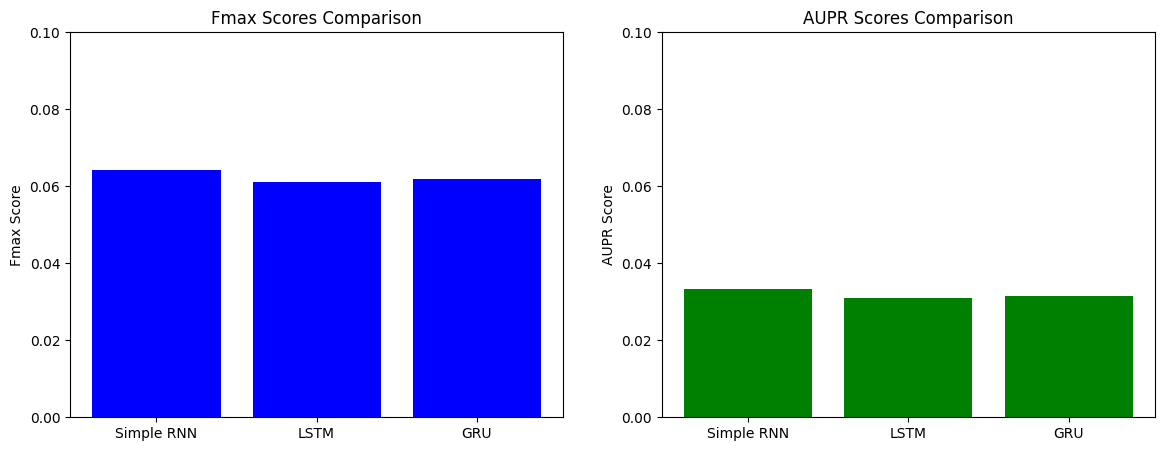

In [ ]:
# Data preparation
models = ['Simple RNN', 'LSTM', 'GRU']
fmax_scores = [fmax_rnn, fmax_lstm, fmax_gru]
aupr_scores = [aupr_rnn, aupr_lstm, aupr_gru]

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Fmax Scores
ax[0].bar(models, fmax_scores, color='blue')
ax[0].set_title('Fmax Scores Comparison')
ax[0].set_ylabel('Fmax Score')
ax[0].set_ylim([0, 0.1])

# AUC Scores
ax[1].bar(models, aupr_scores, color='green')
ax[1].set_title('AUPR Scores Comparison')
ax[1].set_ylabel('AUPR Score')
ax[1].set_ylim([0, 0.1])

plt.show()


#------------------> 2. RNN, LSTM, GRU OPTIMIZATION

#### Models definition § training

In [ ]:
# Define the model architectures
def build_rnn_model(input_shape, num_of_labels):
    model = Sequential([
        layers.Reshape((1, input_shape), input_shape=(input_shape,)),
        layers.SimpleRNN(128, return_sequences=True),
        layers.Dropout(0.3),
        layers.SimpleRNN(128),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_of_labels, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', tf.keras.metrics.AUC()])
    return model

def build_lstm_model(input_shape, num_of_labels):
    model = Sequential([
        layers.Reshape((1, input_shape), input_shape=(input_shape,)),
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(128),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_of_labels, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', tf.keras.metrics.AUC()])
    return model

def build_gru_model(input_shape, num_of_labels):
    model = Sequential([
        layers.Reshape((1, input_shape), input_shape=(input_shape,)),
        layers.GRU(128, return_sequences=True),
        layers.Dropout(0.3),
        layers.GRU(128),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_of_labels, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', tf.keras.metrics.AUC()])
    return model

# Initialize models
model_rnn_simple = build_rnn_model(X_train.shape[1], num_of_labels)
model_lstm = build_lstm_model(X_train.shape[1], num_of_labels)
model_gru = build_gru_model(X_train.shape[1], num_of_labels)

# Setup ModelCheckpoint callbacks
checkpoint_rnn = ModelCheckpoint('/content/drive/My Drive/DATASET/model_rnn_simple_best2.h5', monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_lstm = ModelCheckpoint('/content/drive/My Drive/DATASET/model_lstm_best2.h5', monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_gru = ModelCheckpoint('/content/drive/My Drive/DATASET/model_gru_best2.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Model training with checkpointing
history_rnn_simple = model_rnn_simple.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=50,  # Adjusted number of epochs
    callbacks=[checkpoint_rnn]
)

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=50,  # Adjusted number of epochs
    callbacks=[checkpoint_lstm]
)

history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=50,  # Adjusted number of epochs
    callbacks=[checkpoint_gru]
)



Epoch 1/50
22/23 [===========================>..] - ETA: 0s - loss: 0.3483 - binary_accuracy: 0.9136 - auc_3: 0.5770
Epoch 1: val_loss improved from inf to 0.12769, saving model to /content/drive/My Drive/DATASET/model_rnn_simple_best2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 6s 138ms/step - loss: 0.3462 - binary_accuracy: 0.9142 - auc_3: 0.5777 - val_loss: 0.1277 - val_binary_accuracy: 0.9794 - val_auc_3: 0.7041
Epoch 2/50
22/23 [===========================>..] - ETA: 0s - loss: 0.1004 - binary_accuracy: 0.9789 - auc_3: 0.7738
Epoch 2: val_loss improved from 0.12769 to 0.08026, saving model to /content/drive/My Drive/DATASET/model_rnn_simple_best2.h5
23/23 [==============================] - 2s 75ms/step - loss: 0.1002 - binary_accuracy: 0.9789 - auc_3: 0.7740 - val_loss: 0.0803 - val_binary_accuracy: 0.9799 - val_auc_3: 0.8230
Epoch 3/50
22/23 [===========================>..] - ETA: 0s - loss: 0.0819 - binary_accuracy: 0.9797 - auc_3: 0.8048
Epoch 3: val_loss improved from 0.08026 to 0.07826, saving model to /content/drive/My Drive/DATASET/model_rnn_simple_best2.h5
23/23 [==============================] - 2s 66ms/step - loss: 0.0819 - binary_accuracy: 0.9797 - auc_3: 0.8049 - val_loss: 0.0783 - val_binary_accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 7s 169ms/step - loss: 0.6556 - binary_accuracy: 0.9384 - auc_4: 0.5561 - val_loss: 0.4436 - val_binary_accuracy: 0.9799 - val_auc_4: 0.6152
Epoch 2/50
22/23 [===========================>..] - ETA: 0s - loss: 0.1646 - binary_accuracy: 0.9796 - auc_4: 0.6316
Epoch 2: val_loss improved from 0.44357 to 0.10104, saving model to /content/drive/My Drive/DATASET/model_lstm_best2.h5
23/23 [==============================] - 2s 84ms/step - loss: 0.1640 - binary_accuracy: 0.9796 - auc_4: 0.6328 - val_loss: 0.1010 - val_binary_accuracy: 0.9799 - val_auc_4: 0.7529
Epoch 3/50
22/23 [===========================>..] - ETA: 0s - loss: 0.0865 - binary_accuracy: 0.9797 - auc_4: 0.7962
Epoch 3: val_loss improved from 0.10104 to 0.07917, saving model to /content/drive/My Drive/DATASET/model_lstm_best2.h5
23/23 [==============================] - 2s 79ms/step - loss: 0.0864 - binary_accuracy: 0.9797 - auc_4: 0.7963 - val_loss: 0.0792 - val_binary_accuracy: 0.9799 - val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 7s 159ms/step - loss: 0.5063 - binary_accuracy: 0.9069 - auc_5: 0.5539 - val_loss: 0.0962 - val_binary_accuracy: 0.9799 - val_auc_5: 0.6672
Epoch 2/50
22/23 [===========================>..] - ETA: 0s - loss: 0.1086 - binary_accuracy: 0.9791 - auc_5: 0.7308
Epoch 2: val_loss improved from 0.09619 to 0.08302, saving model to /content/drive/My Drive/DATASET/model_gru_best2.h5
23/23 [==============================] - 2s 80ms/step - loss: 0.1083 - binary_accuracy: 0.9792 - auc_5: 0.7314 - val_loss: 0.0830 - val_binary_accuracy: 0.9800 - val_auc_5: 0.8182
Epoch 3/50
22/23 [===========================>..] - ETA: 0s - loss: 0.0820 - binary_accuracy: 0.9798 - auc_5: 0.8146
Epoch 3: val_loss improved from 0.08302 to 0.07864, saving model to /content/drive/My Drive/DATASET/model_gru_best2.h5
23/23 [==============================] - 2s 71ms/step - loss: 0.0819 - binary_accuracy: 0.9798 - auc_5: 0.8146 - val_loss: 0.0786 - val_binary_accuracy: 0.9799 - val_a

In [ ]:
# Paths of models
path_rnn = '/content/drive/My Drive/DATASET/model_rnn_simple_best2.h5'
path_lstm = '/content/drive/My Drive/DATASET/model_lstm_best2.h5'
path_gru = '/content/drive/My Drive/DATASET/model_gru_best2.h5'

# load models
model_rnn_simple = load_model(path_rnn)
model_lstm = load_model(path_lstm)
model_gru = load_model(path_gru)

In [ ]:
# Display the summary of the RNN model
print("RNN 2 Model Summary:")
model_rnn_simple.summary()

# Display the summary of the LSTM model
print("\nLSTM 2 Model Summary:")
model_lstm.summary()

# Display the summary of the GRU model
print("\nGRU 2 Model Summary:")
model_gru.summary()


RNN 2 Model Summary:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 1, 1024)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1, 128)            147584    
                                                                 
 dropout_9 (Dropout)         (None, 1, 128)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               66048     
                                                                 
 dropout_11 (Dropout)        (Non

#### Models Prediction § Evaluation

In [ ]:
def evaluate_model(model, X, y):
    """Evaluate the model using Fmax and AUPR metrics."""
    # Get model predictions as probabilities
    y_pred_probs = model.predict(X)

    # Ensure y and y_pred_probs are numpy arrays
    if isinstance(y, pd.DataFrame):
        y = y.values
    if isinstance(y_pred_probs, pd.DataFrame):
        y_pred_probs = y_pred_probs.values

    fmax_scores = []
    aupr_scores = []  # Using average_precision_score for simplicity

    # Calculate Fmax and AUPR for each label
    for i in range(y.shape[1]):
        precision, recall, thresholds = precision_recall_curve(y[:, i], y_pred_probs[:, i])
        if len(precision) > 1 and len(recall) > 1:
            f1_scores = 2 * (precision * recall) / (np.maximum(precision + recall, 1e-5))
            fmax = np.max(f1_scores)
            fmax_scores.append(fmax)
            aupr_score = average_precision_score(y[:, i], y_pred_probs[:, i])  # Direct calculation of AUPR
            aupr_scores.append(aupr_score)
        else:
            fmax_scores.append(0)
            aupr_scores.append(0)

    average_fmax = np.mean(fmax_scores)
    average_aupr = np.mean(aupr_scores)  # AUPR directly calculated

    return average_fmax, average_aupr

# Evaluate each model on the test set
fmax_rnn, aupr_rnn = evaluate_model(model_rnn_simple, X_test, y_test)
fmax_lstm, aupr_lstm = evaluate_model(model_lstm, X_test, y_test)
fmax_gru, aupr_gru = evaluate_model(model_gru, X_test, y_test)

# Print the evaluation results
print("Evaluation Results:")
print(f"Simple RNN - Fmax: {fmax_rnn:.4f}, AUPR: {aupr_rnn:.4f}")
print(f"LSTM - Fmax: {fmax_lstm:.4f}, AUPR: {aupr_lstm:.4f}")
print(f"GRU - Fmax: {fmax_gru:.4f}, AUPR: {aupr_gru:.4f}")


In [ ]:
# Comparative Analysis
print(f"Model Performance Comparison:")
print(f"{'Model':<20}{'Fmax':<10}{'AUPR':<10}")
print(f"{'-'*40}")
print(f"{'Simple RNN 2':<20}{fmax_rnn:<10.4f}{aupr_rnn:<10.4f}")
print(f"{'LSTM 2':<20}{fmax_lstm:<10.4f}{aupr_lstm:<10.4f}")
print(f"{'GRU 2':<20}{fmax_gru:<10.4f}{aupr_gru:<10.4f}")

Model Performance Comparison:
Model               Fmax      AUPR      
----------------------------------------
Simple RNN 2        0.2055    0.1301    
LSTM 2              0.0948    0.0515    
GRU 2               0.1377    0.0796    


445/445 [==============================] - 1s 2ms/step


<Figure size 800x600 with 0 Axes>

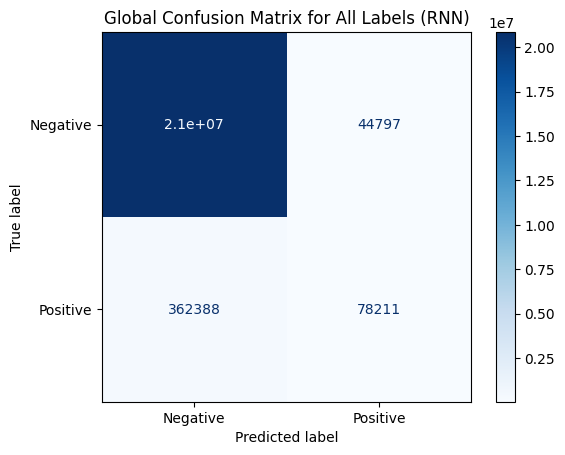

Global Confusion Matrix for RNN:
                          Predicted
               ------------------------------
               Negative     | Positive
Actual Negative    20852104        | 44797
Actual Positive    362388        | 78211
445/445 [==============================] - 2s 2ms/step


<Figure size 800x600 with 0 Axes>

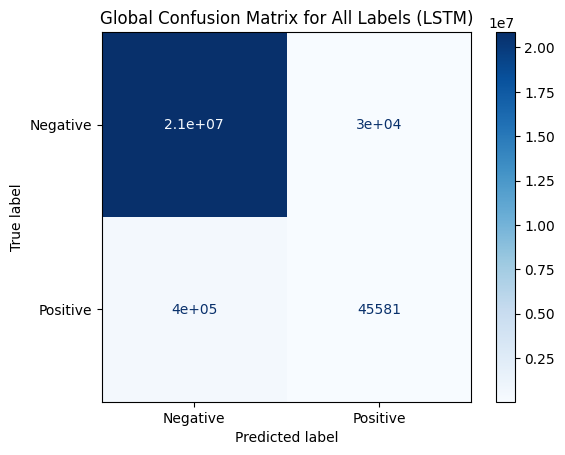

Global Confusion Matrix for LSTM:
                          Predicted
               ------------------------------
               Negative     | Positive
Actual Negative    20866654        | 30247
Actual Positive    395018        | 45581
445/445 [==============================] - 1s 2ms/step


<Figure size 800x600 with 0 Axes>

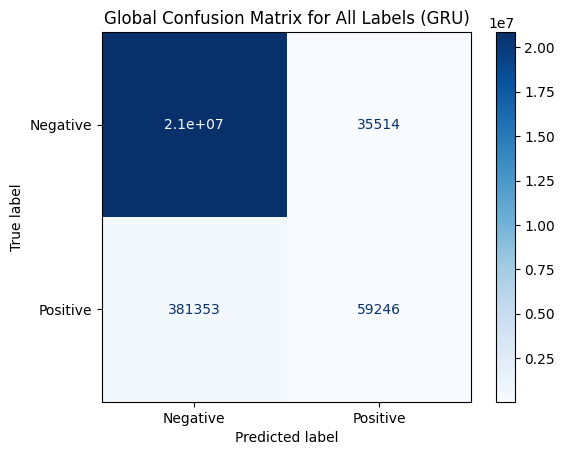

Global Confusion Matrix for GRU:
                          Predicted
               ------------------------------
               Negative     | Positive
Actual Negative    20861387        | 35514
Actual Positive    381353        | 59246


In [ ]:
# models paths
path_rnn = '/content/drive/My Drive/DATASET/model_rnn_simple_best2.h5'
path_lstm = '/content/drive/My Drive/DATASET/model_lstm_best2.h5'
path_gru = '/content/drive/My Drive/DATASET/model_gru_best2.h5'

# model loading
model_rnn = load_model(path_rnn)
model_lstm = load_model(path_lstm)
model_gru = load_model(path_gru)

# if y_test is a  numpy
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values

# the function to  calculate  confusion matrix
def display_confusion_matrix(model, model_name):
    # do the predicitons
    predictions = model.predict(X_test)


    # Threshold for converting probabilities into binary labels
    binary_predictions = (predictions > 0.5).astype(int)

   # Initialize a global confusion matrix
    global_confusion_matrix = np.zeros((2, 2), dtype=int)

   # Calculate confusion matrices for each label and sum them
    NUM_LABELS = 1500
    for i in range(NUM_LABELS):
        cm = confusion_matrix(y_test[:, i], binary_predictions[:, i])
        global_confusion_matrix += cm

   # Display the global confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=global_confusion_matrix, display_labels=['Negative', 'Positive'])
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Global Confusion Matrix for All Labels ({model_name})')
    plt.show()

   # Display the global confusion matrix as a table
    print(f"Global Confusion Matrix for {model_name}:")
    print("                          Predicted")
    print("               ------------------------------")
    print(f"               Negative     | Positive")
    print(f"Actual Negative    {global_confusion_matrix[0, 0]}        | {global_confusion_matrix[0, 1]}")
    print(f"Actual Positive    {global_confusion_matrix[1, 0]}        | {global_confusion_matrix[1, 1]}")

# Calculate and display confusion matrices for each model
display_confusion_matrix(model_rnn, "RNN")
display_confusion_matrix(model_lstm, "LSTM")
display_confusion_matrix(model_gru, "GRU")


# Visualization

In [ ]:
# Data preparation
models = ['Simple RNN', 'LSTM', 'GRU']
fmax_scores = [fmax_rnn, fmax_lstm, fmax_gru]
aupr_scores = [aupr_rnn, aupr_lstm, aupr_gru]

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Fmax Scores
ax[0].bar(models, fmax_scores, color='blue')
ax[0].set_title('Fmax Scores Comparison')
ax[0].set_ylabel('Fmax Score')
ax[0].set_ylim([0, 0.3])

# AUC Scores
ax[1].bar(models, aupr_scores, color='green')
ax[1].set_title('AUPR Scores Comparison')
ax[1].set_ylabel('AUPR Score')
ax[1].set_ylim([0, 0.3])

plt.show()

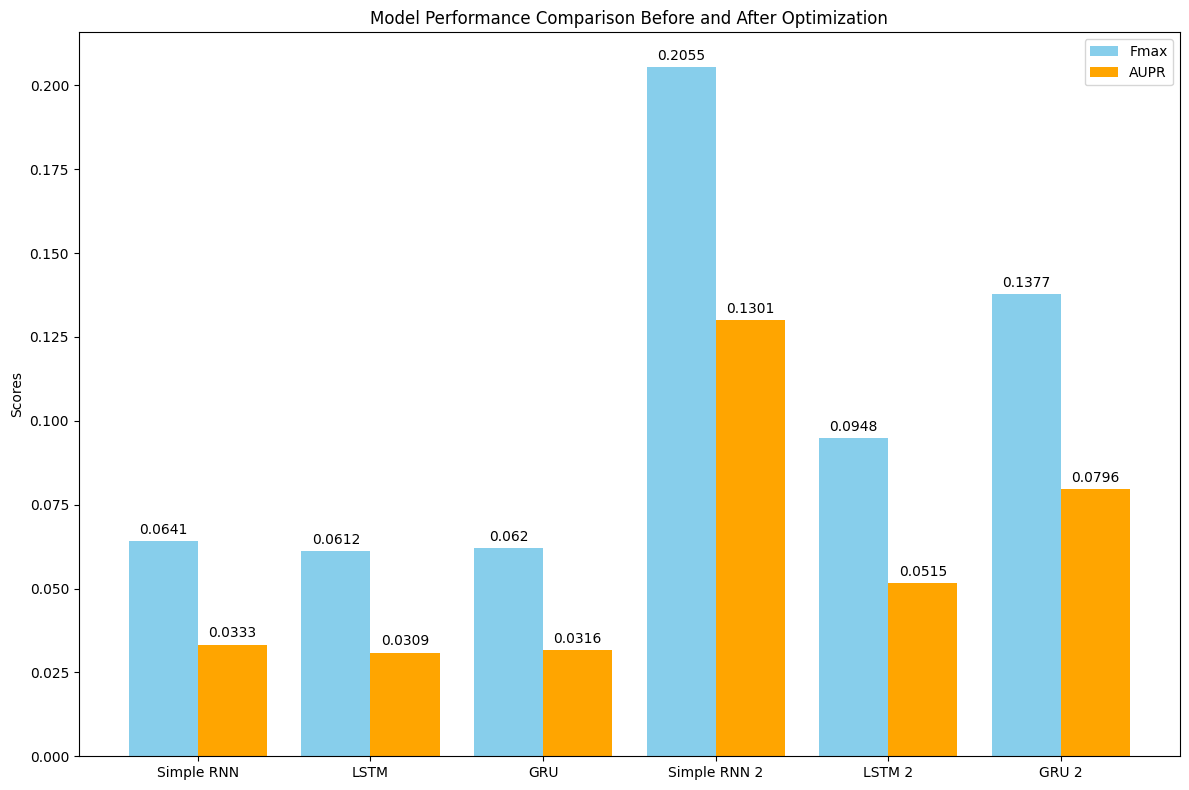

In [ ]:
# Define the data for model comparison
models = ['Simple RNN', 'LSTM', 'GRU', 'Simple RNN 2', 'LSTM 2', 'GRU 2']
fmax_scores = [0.0641, 0.0612, 0.0620, 0.2055, 0.0948, 0.1377]
aupr_scores = [0.0333, 0.0309, 0.0316, 0.1301, 0.0515, 0.0796]

# Prepare positions on the x-axis for each model's bar set
x = np.arange(len(models))  # the label locations

# Create the bar plots
fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - 0.2, fmax_scores, 0.4, label='Fmax', color='skyblue')
rects2 = ax.bar(x + 0.2, aupr_scores, 0.4, label='AUPR', color='orange')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison Before and After Optimization')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Function to add labels to the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Show the plot
fig.tight_layout()

plt.show()


Visualizing RNN_v1...


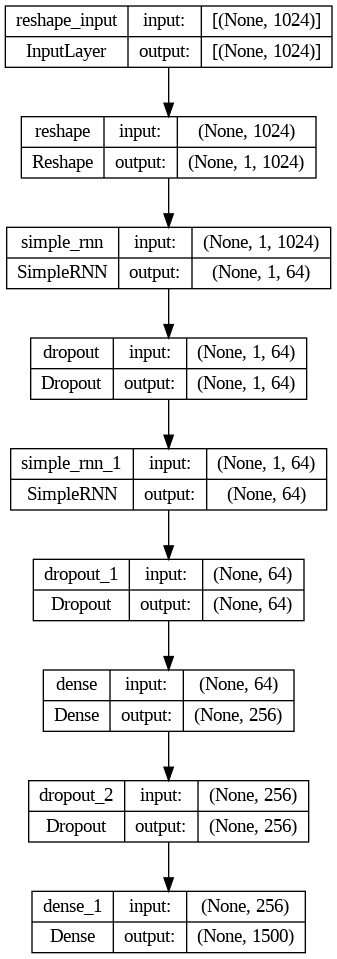

Visualizing RNN_v2...


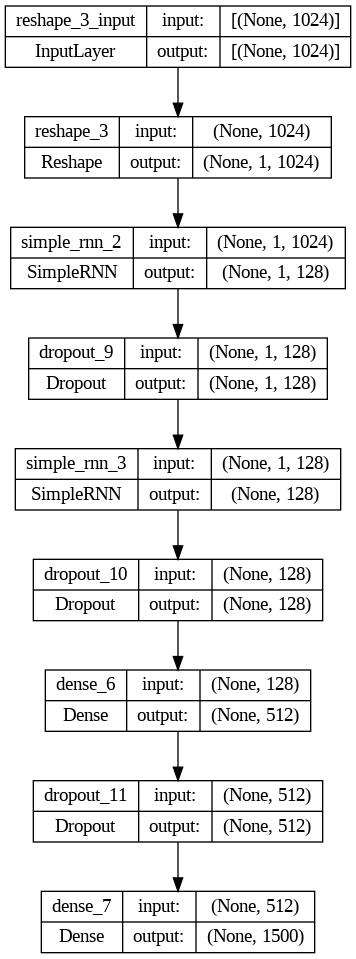

Visualizing LSTM_v1...


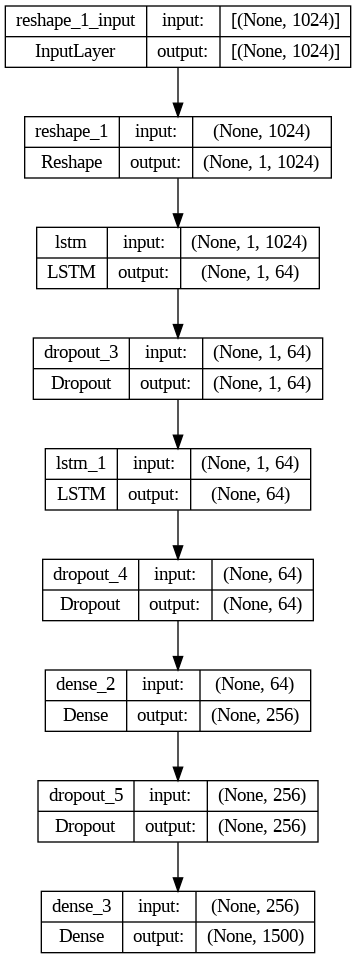

Visualizing LSTM_v2...


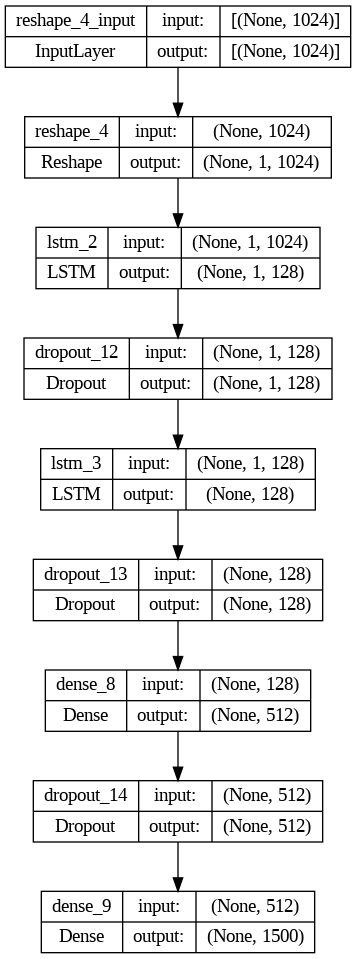

Visualizing GRU_v1...


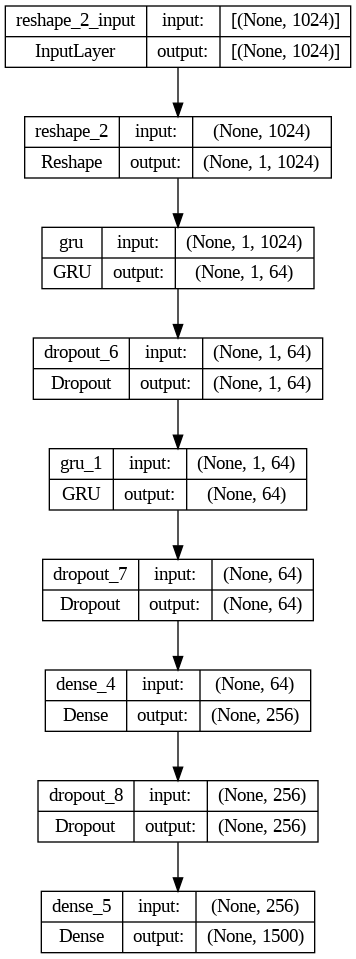

Visualizing GRU_v2...


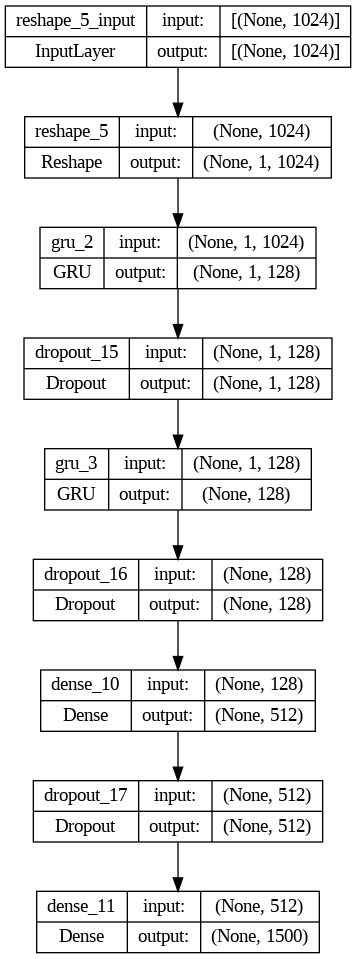

In [ ]:
# Chemins des modèles
model_paths = {
    'RNN_v1': '/content/drive/My Drive/DATASET/model_rnn_simple_best.h5',
    'RNN_v2': '/content/drive/My Drive/DATASET/model_rnn_simple_best2.h5',
    'LSTM_v1': '/content/drive/My Drive/DATASET/model_lstm_best.h5',
    'LSTM_v2': '/content/drive/My Drive/DATASET/model_lstm_best2.h5',
    'GRU_v1': '/content/drive/My Drive/DATASET/model_gru_best.h5',
    'GRU_v2': '/content/drive/My Drive/DATASET/model_gru_best2.h5'
}

# Fonction pour charger, visualiser et afficher l'architecture de chaque modèle
def visualize_model_architecture(model_path, model_name):
    # Charger le modèle
    model = load_model(model_path)

    # Nom du fichier image
    image_file = f'{model_name}_structure.png'

    # Visualiser l'architecture
    plot_model(model, to_file=image_file, show_shapes=True, show_layer_names=True)

    # Afficher l'image
    display(Image(filename=image_file))

# Visualiser chaque modèle
for model_name, path in model_paths.items():
    print(f"Visualizing {model_name}...")
    visualize_model_architecture(path, model_name)


#Train Models With Updated Label Dataframe

In [ ]:

# Define the path to the pickle file
pickle_path = "/content/drive/My Drive/DATASET/updated00_labels_df.pkl"

# load labels_df from the pickle file
labels_df = pd.read_pickle(pickle_path)
print("Loaded labels_df from pickle.")


# Ensure train_embeds has the shape (num_samples, sequence_length, embedding_dim)
# Adding a new axis to have shape (142246, 1024, 1)
train_embeds = np.expand_dims(train_embeds, axis=-1)

# Proceed with splitting the datasets
# First, split the data into a training set and a temporary testing set
X_train, X_temp, y_train, y_temp = train_test_split(
    train_df, labels_df, test_size=0.2, random_state=42
)

# Next, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Display the dimensions of the sets to verify proper splitting
print(f"Training set dimensions: {X_train.shape}, {y_train.shape}")
print(f"Validation set dimensions: {X_val.shape}, {y_val.shape}")
print(f"Test set dimensions: {X_test.shape}, {y_test.shape}")


Loaded labels_df from pickle.
Training set dimensions: (113796, 1024), (113796, 1500)
Validation set dimensions: (14225, 1024), (14225, 1500)
Test set dimensions: (14225, 1024), (14225, 1500)


In [ ]:
 #Data configuration
INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 512
num_of_labels = y_train.shape[1]

# Define the model architectures
def build_rnn_model(input_shape, num_of_labels):
    model = Sequential([
        layers.Reshape((1, input_shape), input_shape=(input_shape,)),
        layers.SimpleRNN(128, return_sequences=True),
        layers.Dropout(0.3),
        layers.SimpleRNN(128),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_of_labels, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', tf.keras.metrics.AUC()])
    return model

def build_lstm_model(input_shape, num_of_labels):
    model = Sequential([
        layers.Reshape((1, input_shape), input_shape=(input_shape,)),
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(128),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_of_labels, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', tf.keras.metrics.AUC()])
    return model

def build_gru_model(input_shape, num_of_labels):
    model = Sequential([
        layers.Reshape((1, input_shape), input_shape=(input_shape,)),
        layers.GRU(128, return_sequences=True),
        layers.Dropout(0.3),
        layers.GRU(128),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_of_labels, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', tf.keras.metrics.AUC()])
    return model

# Initialize models
model_rnn_simple = build_rnn_model(X_train.shape[1], num_of_labels)
model_lstm = build_lstm_model(X_train.shape[1], num_of_labels)
model_gru = build_gru_model(X_train.shape[1], num_of_labels)

# Setup ModelCheckpoint callbacks
checkpoint_rnn = ModelCheckpoint('/content/drive/My Drive/DATASET/model_rnn_simple_best0.h5', monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_lstm = ModelCheckpoint('/content/drive/My Drive/DATASET/model_lstm_best0.h5', monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_gru = ModelCheckpoint('/content/drive/My Drive/DATASET/model_gru_best0.h5', monitor='val_loss', save_best_only=True, verbose=1)


history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=50,
    callbacks=[checkpoint_gru]
)



Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 0.6187 - binary_accuracy: 0.7421 - auc_5: 0.7365
Epoch 1: val_loss improved from inf to 0.47864, saving model to /content/drive/My Drive/DATASET/model_gru_best0.h5
23/23 [==============================] - 48s 2s/step - loss: 0.6187 - binary_accuracy: 0.7421 - auc_5: 0.7365 - val_loss: 0.4786 - val_binary_accuracy: 0.7908 - val_auc_5: 0.8209
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - ETA: 0s - loss: 0.4526 - binary_accuracy: 0.7851 - auc_5: 0.8236
Epoch 2: val_loss improved from 0.47864 to 0.44035, saving model to /content/drive/My Drive/DATASET/model_gru_best0.h5
23/23 [==============================] - 44s 2s/step - loss: 0.4526 - binary_accuracy: 0.7851 - auc_5: 0.8236 - val_loss: 0.4403 - val_binary_accuracy: 0.7908 - val_auc_5: 0.8320
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 0.4413 - binary_accuracy: 0.7893 - auc_5: 0.8312
Epoch 3: val_loss improved from 0.44035 to 0.43711, saving model to /content/drive/My Drive/DATASET/model_gru_best0.h5
23/23 [==============================] - 47s 2s/step - loss: 0.4413 - binary_accuracy: 0.7893 - auc_5: 0.8312 - val_loss: 0.4371 - val_binary_accuracy: 0.7908 - val_auc_5: 0.8325
Epoch 4/50
23/23 [==============================] - ETA: 0s - loss: 0.4394 - binary_accuracy: 0.7897 - auc_5: 0.8325
Epoch 4: val_loss improved from 0.43711 to 0.43629, saving model

OSError: [Errno 5] Unable to create file (unable to open file: name = '/content/drive/My Drive/DATASET/model_gru_best0.h5', errno = 5, error message = 'Input/output error', flags = 13, o_flags = 242)